In [2]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt, prettytable as pt
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(""))))

# Dados da Simulação

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
Nome da Variável,Vmed_B1:1,Vmed_B1:2,Vmed_B1:3,Imed_B1:1,Imed_B1:2,Imed_B1:3,Vmed_B2:1,Vmed_B2:2,Vmed_B2:3,Imed_B2:1,...,Vmed_B4_A4:3,Imed_B4_A4:1,Imed_B4_A4:2,Imed_B4_A4:3,Vmed_B4_A5:1,Vmed_B4_A5:2,Vmed_B4_A5:3,Imed_B4_A5:1,Imed_B4_A5:2,Imed_B4_A5:3


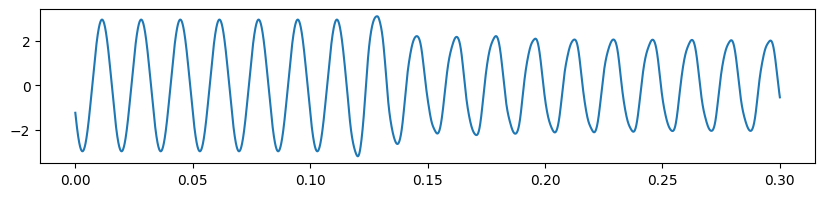

In [3]:
# from functions.ProcessamentoCSV import Dunno
i_col = 3*3
t_simulation = 0.3
fs = 30720
nSamples = int(t_simulation * fs)
pontos_de_medicao = pd.read_csv('medicoes.csv', header=None, dtype= str, names=["Nome da Variável"])
display(pontos_de_medicao.T)
all_signals = np.genfromtxt('caso_1_.csv', delimiter=',', skip_header=0)
signal = all_signals[:, i_col]
t = np.linspace(0, t_simulation, signal.shape[0])
plt.figure(figsize=(10, 2))
graph = plt.plot(t, signal, label=f'Caso 1 - {pontos_de_medicao.iloc[i_col]}')

# Rotina Transformada de Fourier

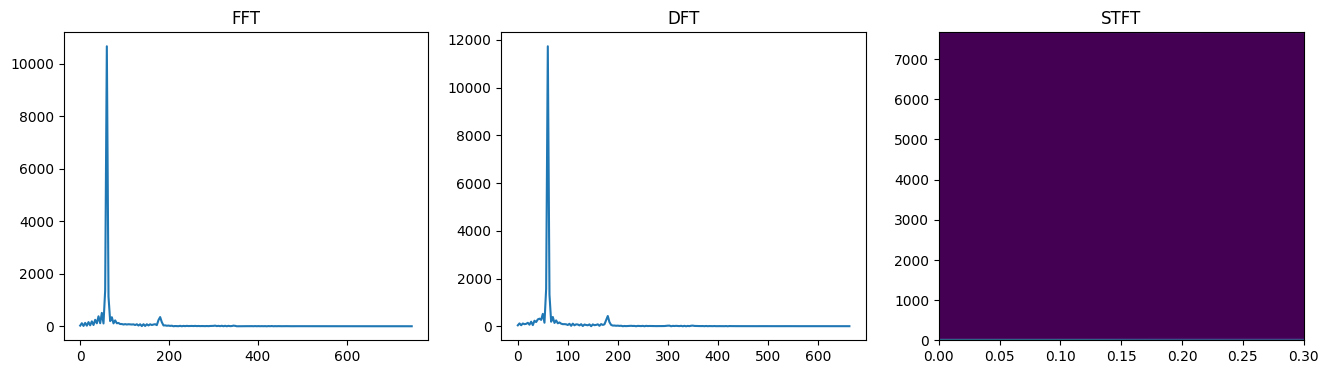

In [4]:
from functions.TF import FFT_function, DFT_function, STFT_function

signal_fft = FFT_function.FFT(signal[0:2**13]) # Precisa Remover o "np.concatenate" ou adicionar padding no vetor de entrada

signal_dft = DFT_function.discrete_fourier_transform.DFT(signal)

frame_size = 0.05
nFrames = int(t_simulation / frame_size)
nSamplesPerFrame = int(frame_size * fs)
hop = int((nSamples - nSamplesPerFrame) / (nFrames - 1))/fs
signal_stft = STFT_function.short_time_fourier_transform.STFT(signal, fs, frame_size, hop)

freq_fft = np.fft.fftfreq(signal_fft.shape[0], 1/fs)
freq_dft = np.fft.fftfreq(signal_dft.shape[0], 1/fs)
freq_stft = np.fft.fftshift(np.fft.fftfreq(nSamplesPerFrame, d=1/fs))

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(freq_fft[0:200], np.abs(signal_fft[0:200]), label='FFT')
plt.title('FFT')
plt.subplot(1,3,2)
plt.plot(freq_dft[0:200], np.abs(signal_dft[0:200]), label='DFT')
plt.title('DFT')
plt.subplot(1,3,3)
Fz = int(frame_size * fs * t_simulation)
plt.imshow(np.abs(signal_stft.T), aspect='auto', origin='lower',
           extent=[t.min(), t.max(), 0, freq_stft.max()//2])
plot = plt.title('STFT')

# Rotina Transformada Wavelet

Text(0.5, 1.0, 'cD')

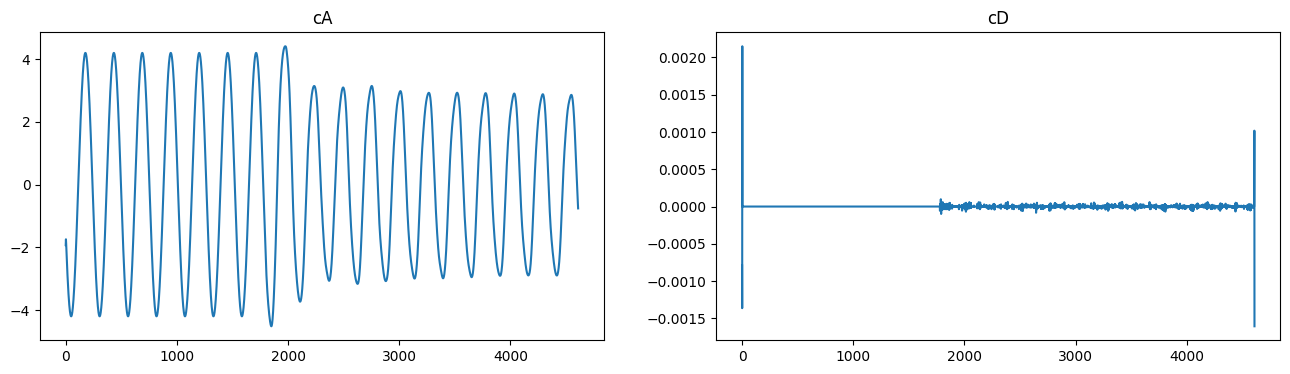

In [5]:
from functions.TW import DTW

signal_dwt = DTW.DWT.transform(signal, wavelet ='db4')
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(signal_dwt[0], label='cA')
plt.title("cA")
plt.subplot(1,2,2)
plot = plt.plot(signal_dwt[1], label='cD')
plt.title("cD")

# Rotina Transformada de Stockwell

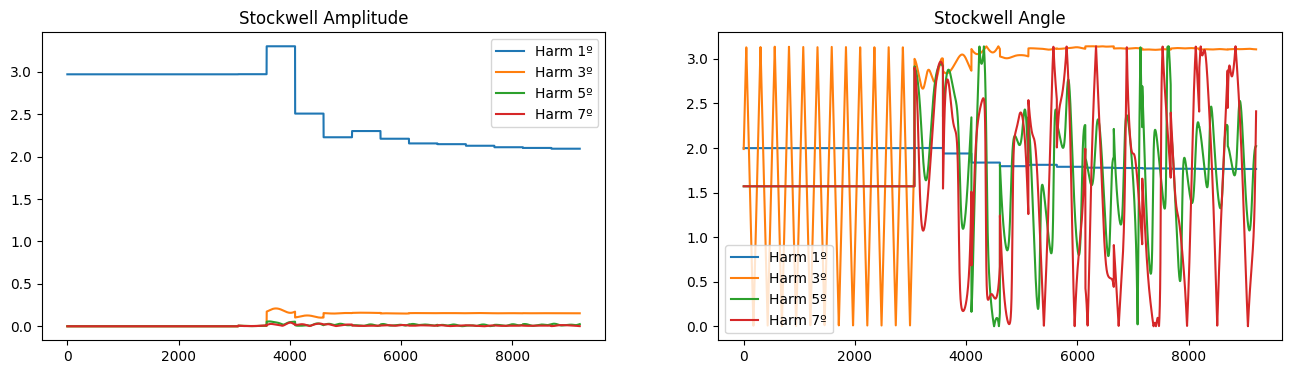

In [6]:
from functions.TS import ST
stClass = ST.Stockwell()
signal_ST = stClass.calcula_TS_do_sinal(signal, int(fs/60), 1)

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
for i in range(1, 9, 2):
    plt.plot(signal_ST[0][i, :], label=f'Harm {i}º')
plt.title('Stockwell Amplitude')
plt.legend()

plt.subplot(1,2,2)
for i in range(1, 9, 2):
    plt.plot(signal_ST[1][i, :], label=f'Harm {i}º')
plt.title('Stockwell Angle')
plt.legend()

# Rotina Transformada Trifásica

Text(0.5, 1.0, 'Transformada de Park')

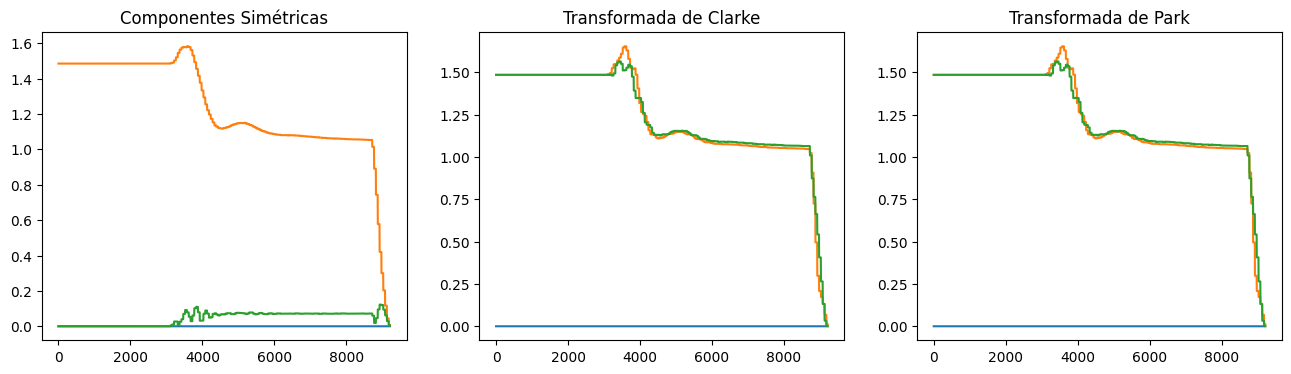

In [7]:
from functions.TT import clarke, park, componentes_simetricas
Va = np.fft.fft(all_signals[:, i_col])[int(60*0.3)]/nSamples
Vb = np.fft.fft(all_signals[:, i_col+1])[int(60*0.3)]/nSamples
Vc = np.fft.fft(all_signals[:, i_col+2])[int(60*0.3)]/nSamples

window = int(fs/60)
window_step = int(0.1/60*fs)
signal_compSym = np.zeros((nSamples, 3), dtype=complex)
signal_clarke = np.zeros((nSamples, 3), dtype=complex)
signal_park = np.zeros((nSamples, 3), dtype=complex)
i = 0
while i < nSamples:
    Va = np.fft.fft(all_signals[i:i+window, i_col])[1]/window
    Vb = np.fft.fft(all_signals[i:i+window, i_col+1])[1]/window
    Vc = np.fft.fft(all_signals[i:i+window, i_col+2])[1]/window
    signal_compSym[i:i+window_step] = componentes_simetricas.comp_sim_ABCto012(Va, Vb, Vc)
    signal_clarke[i:i+window_step] = clarke.clarke_ABCtoAB0(Va, Vb, Vc)
    signal_park[i:i+window_step] = park.park_ABCtoDQ(Va, Vb, Vc, 0)
    i += window_step

plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(np.abs(signal_compSym), label='Componentes Simétricas')
plt.title('Componentes Simétricas')
plt.subplot(1,3,2)
plt.plot(np.abs(signal_clarke), label='Transformada de Clarke')
plt.title('Transformada de Clarke')
plt.subplot(1,3,3)
plot = plt.plot(np.abs(signal_park), label='Transformada de Park')
plt.title('Transformada de Park')

## Variational Mode Decomposition (VMD) algorithm.

c:\Users\alail\OneDrive\Documentos\Github\preprocessing\functions\VMD\VMD.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  u[:, k] = np.fft.ifft(np.fft.fft(X) / (alpha_k[:, k] + 1j * omega[:, k]))


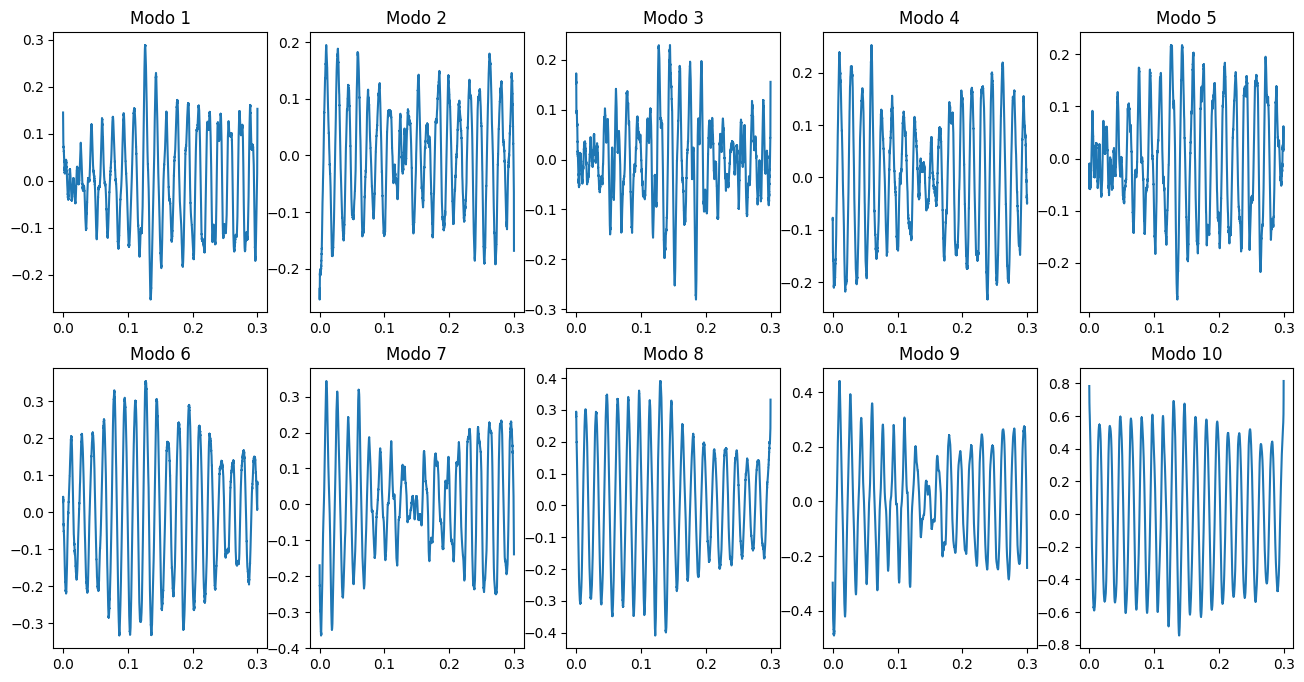

In [11]:
from functions.VMD import VMD

signal_vmd = VMD.vmd(signal)
nRow = 2
plt.figure(figsize=(16, 8))
for i, modes in enumerate(signal_vmd.T):
    plt.subplot(nRow, signal_vmd.shape[1]//nRow, i+1)
    plt.plot(t, modes)
    plt.title(f'Modo {i+1}')

# EMD

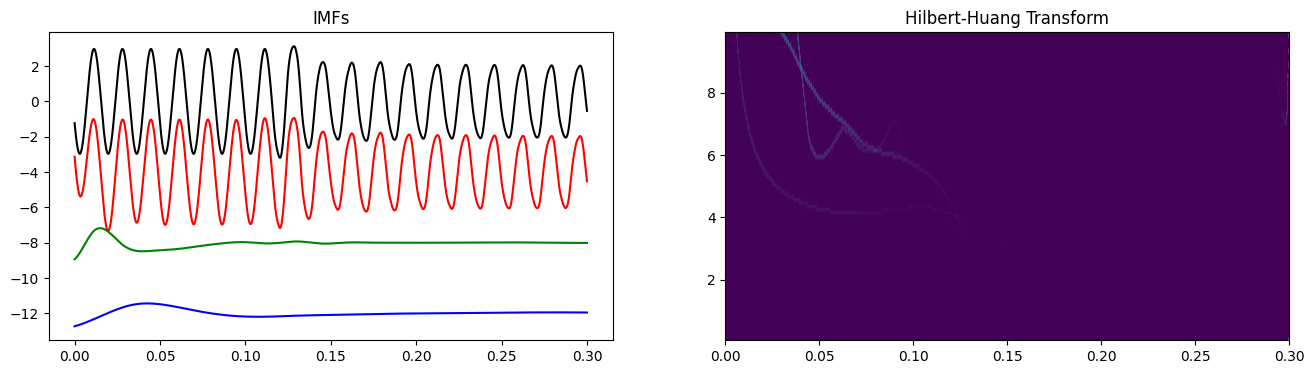

In [9]:
import emd

imf = emd.sift.sift(signal)
IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'hilbert')
freq_range = (0, 10, 100)  # 0 to 10Hz in 50 steps
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(t, signal, 'k')
plt.plot(t, imf[:, 0]-4, 'r')
plt.plot(t, imf[:, 1]-8, 'g')
plt.plot(t, imf[:, 2]-12, 'b')
plt.title('IMFs')
plt.subplot(1,2,2)
plt.contourf(t, f, hht, 100)
plot = plt.title('Hilbert-Huang Transform')